In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

{'top/short_tshirt': 107, 'top/jeans': 264, 'top/long_tshirt': 270, 'top/hood_tshirt': 390, 'top/hood_zipup': 244, 'top/shirt': 118, 'top/slacks': 554, 'top/short_shirt': 74, 'top/short_skirt': 189, 'top/short_pants': 200, 'top/long_skirt': 70, 'top/cardigan': 174, 'top/bouble_coat': 331, 'top/denim_jacket': 311, 'top/blouson': 628, 'outer/short_onepiece': 1800, 'outer/long_onepiece': 1554, 'outer/suit_jacket': 1800, 'outer/single_coat': 1025, 'outer/long_padded': 146, 'outer/short_padded': 1800, 'outer/fleece': 440, 'outer/short_knit': 1800, 'outer/long_knit': 659, 'outer/train_top': 1311, 'outer/train_pants': 1800, 'outer/rider_jacket': 1293}


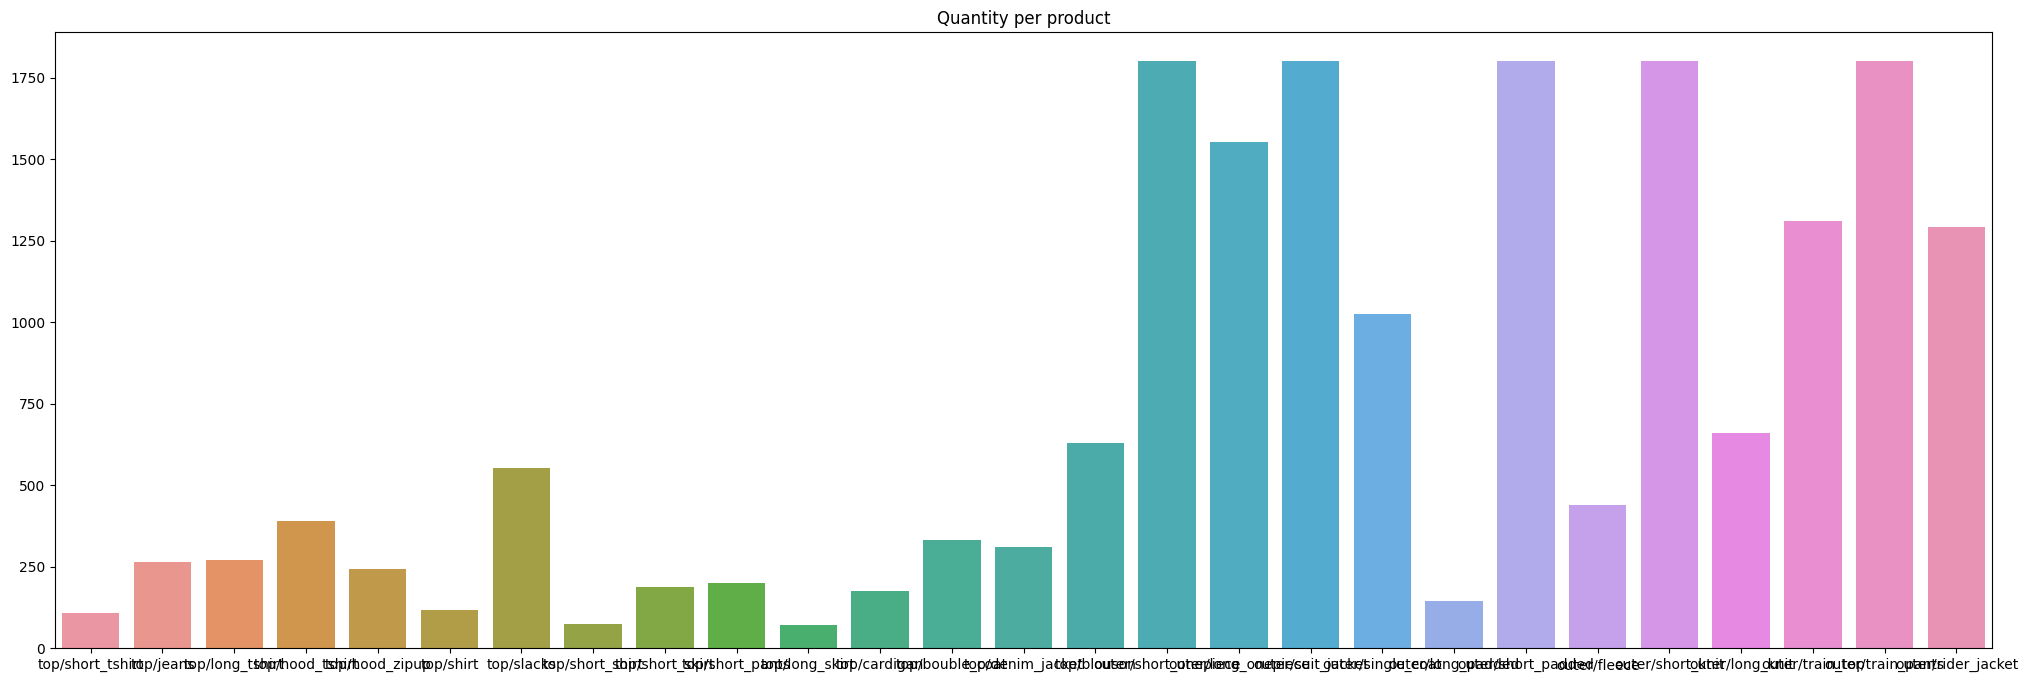

In [ ]:
# 옷 종류 확인하기
PATH = "/content/drive/MyDrive/"
top_list = os.listdir(PATH+"top/")
outer_list = os.listdir(PATH+"outer/")
cloths_list = top_list+outer_list

cloth_cnt = {}

for top_type in top_list:
  cloth_cnt[f"top/{top_type}"] = len(os.listdir(PATH+f"top/{top_type}/"))

for outer_type in outer_list:
  cloth_cnt[f"outer/{outer_type}"] = len(os.listdir(PATH+f"outer/{outer_type}"))

print(cloth_cnt)

plt.figure(figsize=(25,8))
sns.barplot(x=list(cloth_cnt.keys()), y=list(cloth_cnt.values()))
plt.title("Quantity per product")
plt.show()

In [ ]:
# 500개 이상인 옷만 별도 분류
data_list = []
for name, cnt in cloth_cnt.items():
  if cnt >= 500:
    data_list.append(name)

In [ ]:
data_list

['top/slacks',
 'top/blouson',
 'outer/short_onepiece',
 'outer/long_onepiece',
 'outer/suit_jacket',
 'outer/single_coat',
 'outer/short_padded',
 'outer/short_knit',
 'outer/long_knit',
 'outer/train_top',
 'outer/train_pants',
 'outer/rider_jacket']

# 데이터셋 정의

In [ ]:
data_path_list = []
data_class_list = []
for cloth_type in data_list:
  tmp = os.listdir(PATH+f"{cloth_type}/")
  for filename in tmp:
    data_path_list.append(PATH+f"{cloth_type}/{filename}")
  data_class_list.extend([cloth_type]*len(tmp))

In [ ]:
encoder = LabelEncoder()
encoded_class_list = encoder.fit_transform(data_class_list)
encoded_class_list[:5]

array([11, 11, 11, 11, 11])

In [54]:
class clothdataset(object):
  def __init__(self, paths_list, labels_list=None, transform=None):
    self.paths_list = paths_list
    self.labels_list = labels_list
    self.transform = transform

  def __len__(self):
    return len(self.paths_list)

  def __getitem__(self, idx):
    img = Image.open(self.paths_list[idx])
    if self.transform:
      img = self.transform(img)
    if self.labels_list:
      return img, self.labels_list[idx]
    else: return img

In [55]:
train_x, val_x, train_y, val_y = train_test_split(data_path_list, encoded_class_list, random_state=12, stratify=encoded_class_list, test_size=0.2)

In [56]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [58]:
train_dataset = clothdataset(train_x, train_y, transform=transform)
val_dataset = clothdataset(val_x, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# 모델 정의

In [38]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, 1, 1),
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(3, 64, 1, 1),
        nn.ReLU()
    )
    self.fc = nn.Linear(64*224*224, CLASSES)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.fc(x)
    return x

In [37]:
def train():
  for epoch in EPOCH:
    for x, y in tqdm(train_dataloader):
      x = x.to(device)
      y = y.to(device)
      output = model(x)
      loss = loss_fn(output, y)
      optimizer.step()


In [41]:
EPOCH = 5
CLASSES = 12